In [1]:
# Импорт необходимых библиотек
import copy
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from dateutil.relativedelta import relativedelta

# Source: https://www.statsmodels.org/stable/install.html
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Source: https://scikit-learn.org/stable/install.html
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

plt.style.use('dark_background')

%matplotlib inline

In [2]:
df = pd.read_csv('./Amazon_Historical_StockPrice2.csv')
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1.260000e+03
mean,1677.254199,1694.635633,1657.249580,1676.504673,1676.504673,4.318210e+06
std,787.593224,798.250932,774.769809,786.149289,786.149289,2.089566e+06
min,580.150024,584.750000,575.559998,579.869995,579.869995,8.813000e+05
25%,967.990005,974.467499,959.544983,966.027512,966.027512,2.908675e+06
50%,1676.494995,1698.104980,1654.445007,1671.174988,1671.174988,3.716250e+06
75%,1932.977478,1951.877502,1908.004974,1928.965027,1928.965027,5.122475e+06
max,3547.000000,3552.250000,3486.689941,3531.449951,3531.449951,1.656500e+07


In [3]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

df.sort_values(by='Date', inplace=True)

In [4]:
# days = 5
# seasonal = 365 // days
seasonal = 12

In [5]:
sz = df.shape[0]

# ids = np.repeat(np.arange(0, (sz + days - 1) // days), days)
# ids.resize(sz)
def month(a):
    return a.date().month
ids = (df['Date'].map(month) != df['Date'].shift().map(month)).cumsum()
df2 = df.groupby(ids).max()
df2['Date'] = df['Date'].groupby(ids).first()
df = df2
df = df.set_index(['Date'])
df.sort_index(inplace=True)
df.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-03-28,599.280029,603.23999,595.00000,598.690002,598.690002,4392600
2016-04-01,666.000000,669.97998,654.00000,659.590027,659.590027,10310700
2016-05-02,717.380005,724.22998,711.51001,722.789978,722.789978,7338200


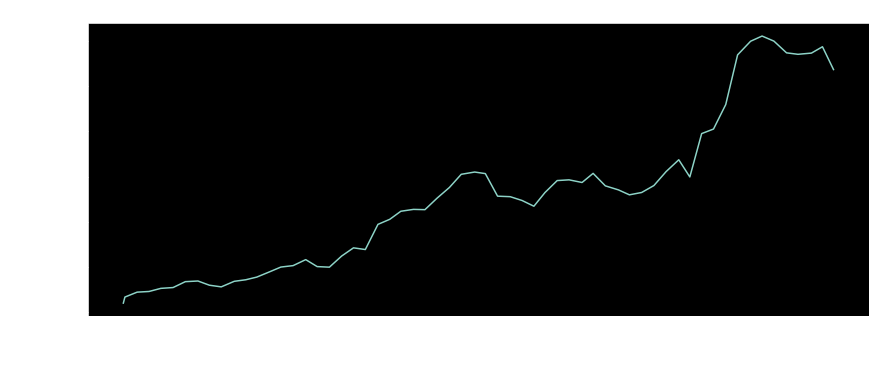

In [6]:
plt.figure(figsize=(14, 6))
plt.title('Time series example')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', rotation=0, labelpad=30, fontsize=15)
df['High'].plot();

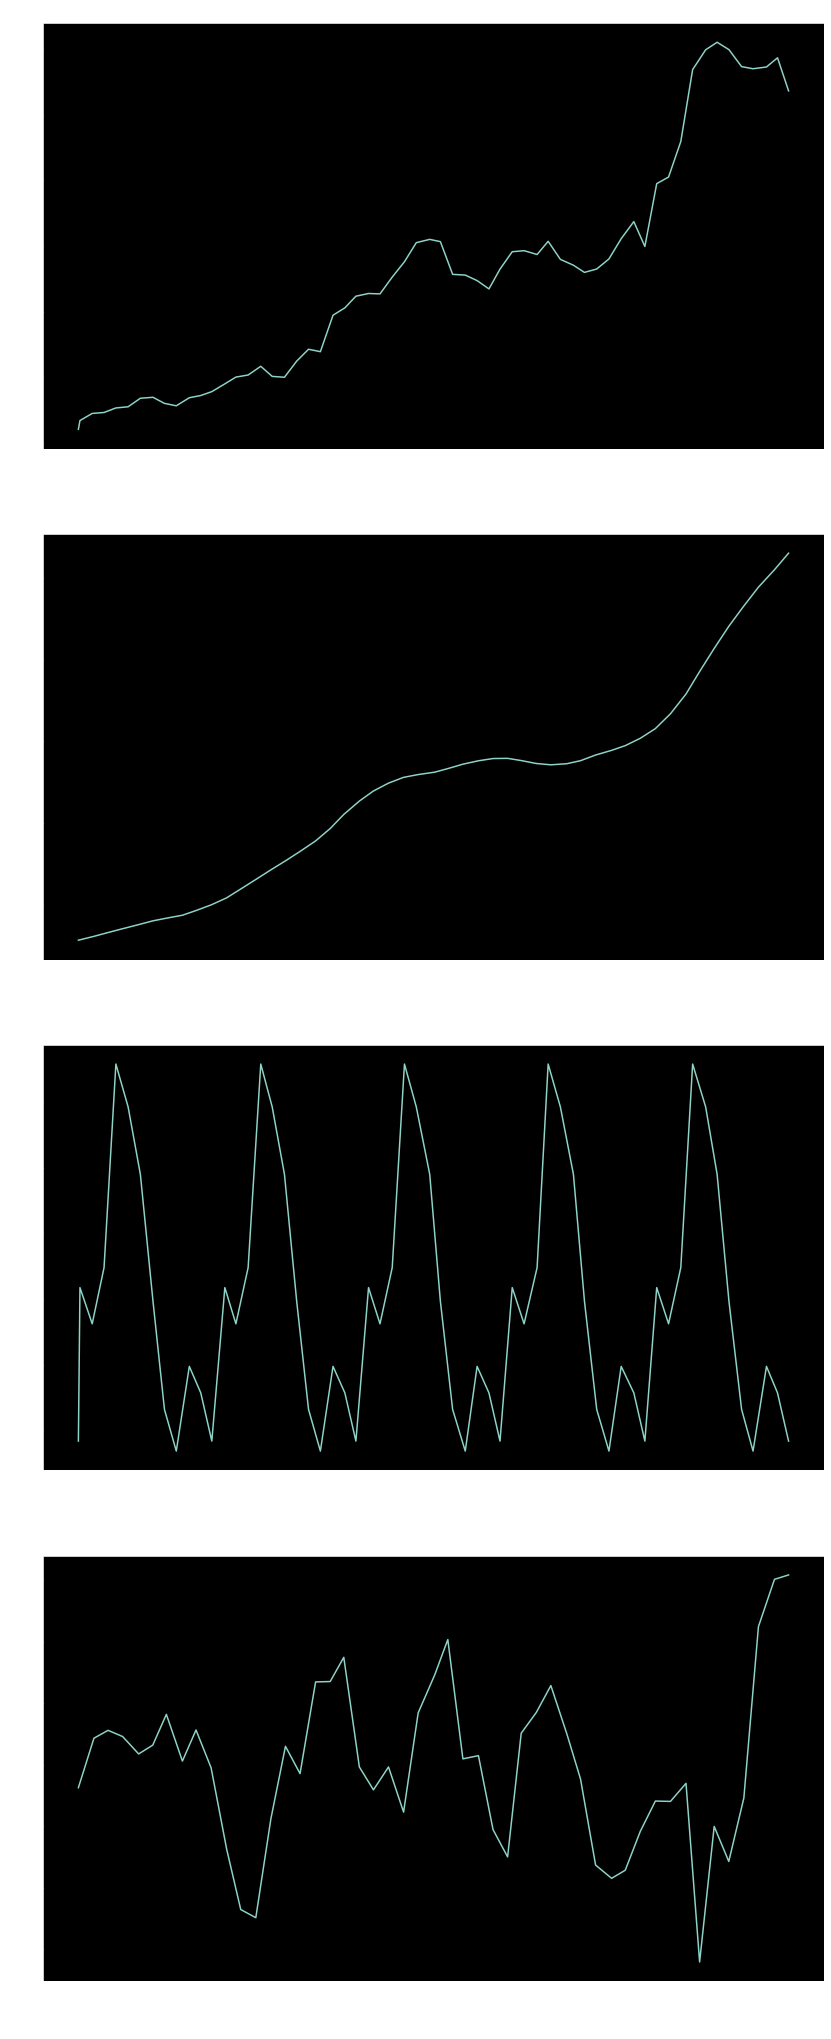

In [7]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 40))

decompose = seasonal_decompose(df[['High']], period=seasonal)

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3]);

In [8]:
X = df.index
y = df['High']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

train = pd.Series(y_train, X_train)
test = pd.Series(y_test, X_test)

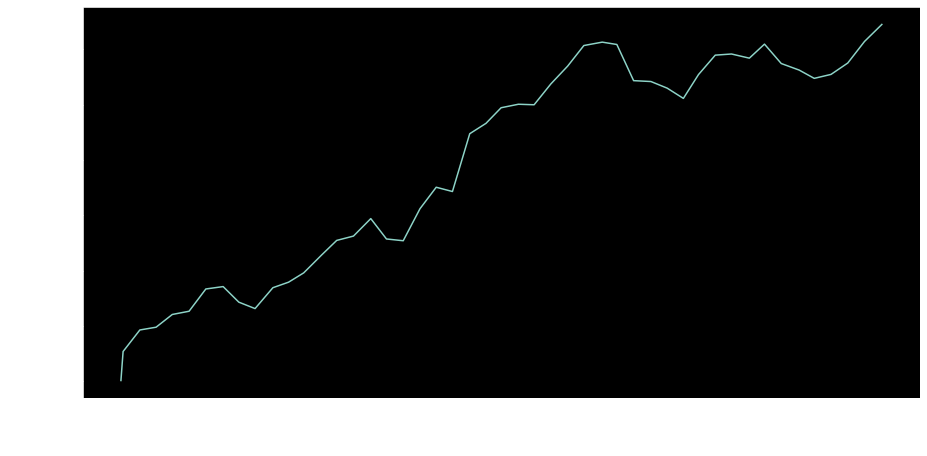

In [9]:
valueLog = np.log(train)

plt.figure(figsize=(15, 8))
plt.ylabel('ValueLog', rotation=0, labelpad=30)
valueLog.plot();

Полученный уровень значимости (p-value): 0.0278. 0.0278 < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!


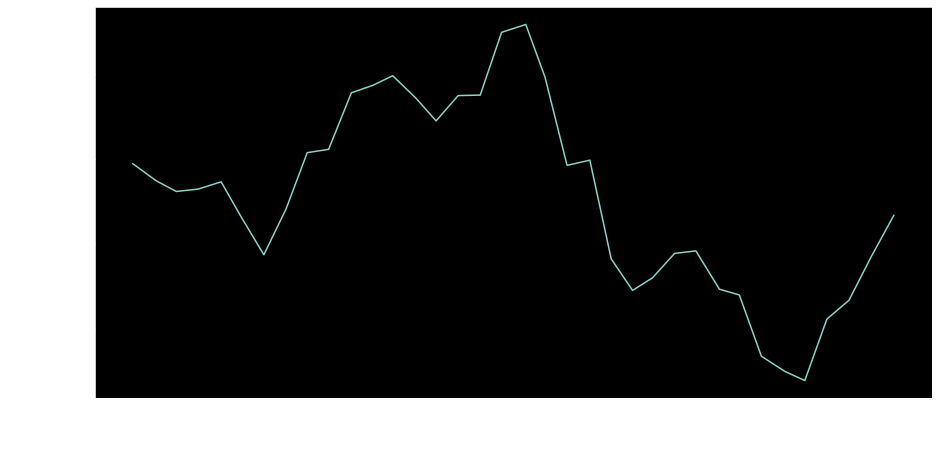

In [10]:
valueLogSDiff = valueLog - valueLog.shift(seasonal)
p_value = adfuller(valueLogSDiff[seasonal:])[1]

print(
    f'Полученный уровень значимости (p-value): {round(p_value, 4)}.',
    f'{round(p_value, 4)} < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!'
)

plt.figure(figsize=(15, 8))
plt.ylabel('ValueLogSDiff', rotation=0, labelpad=30)
valueLogSDiff.plot();

Полученный уровень значимости (p-value): 0.0008. 0.0008 < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!


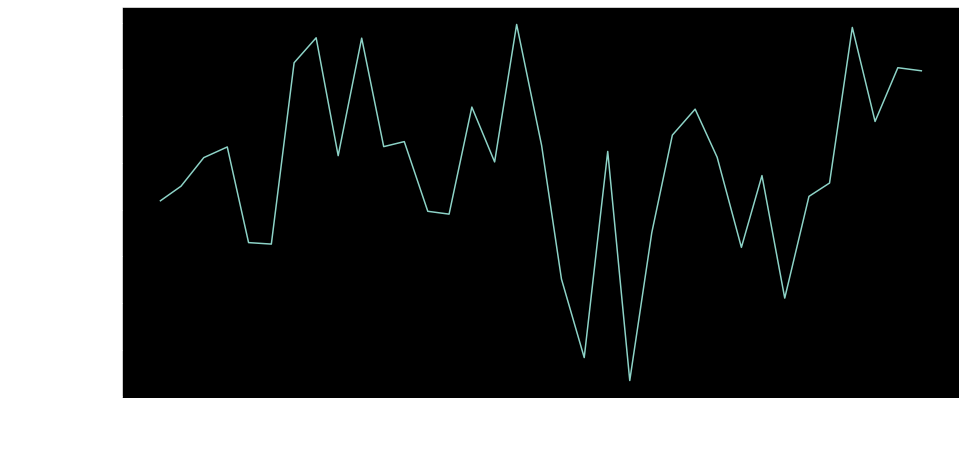

In [11]:
valueLogSDiffODiff = valueLogSDiff - valueLogSDiff.shift(1)
p_value = adfuller(valueLogSDiffODiff[(seasonal+1):])[1]

print(
    f'Полученный уровень значимости (p-value): {round(p_value, 4)}.',
    f'{round(p_value, 4)} < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!'
)

plt.figure(figsize=(15, 8))
plt.ylabel('ValueLogSDiffODiff', rotation=0, labelpad=30)
valueLogSDiffODiff.plot();

x:\python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


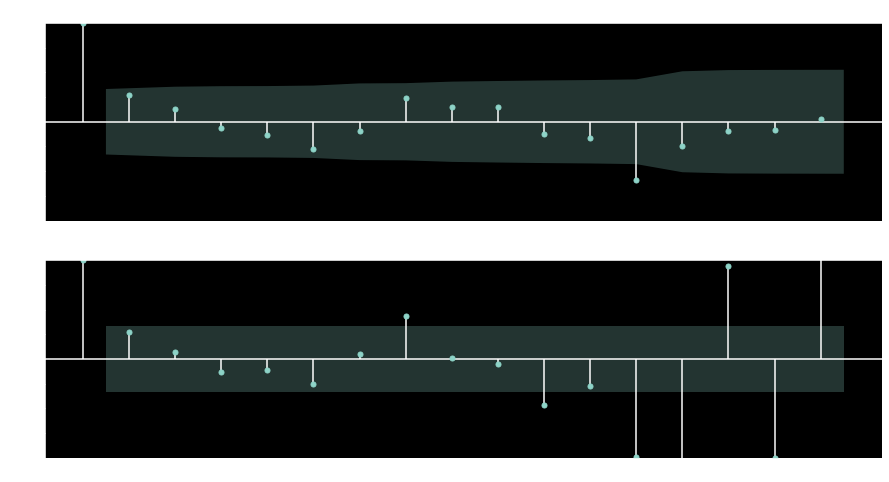

In [12]:
plt.figure(figsize=(15,8))

ax = plt.subplot(211)
statsmodels.graphics.tsaplots.plot_acf(valueLogSDiffODiff[(seasonal+1):], ax=ax)

ax = plt.subplot(212)
statsmodels.graphics.tsaplots.plot_pacf(valueLogSDiffODiff[(seasonal+1):], ax=ax);

In [13]:
import warnings

d=1
D=1

qs = range(1, 5)
Qs = range(1, 3)

ps = range(1, 5)
Ps = range(3, 5)

from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

warnings.filterwarnings('ignore')
import statsmodels.api as sm


In [14]:
%%time
results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    try:
        model = sm.tsa.statespace.SARIMAX(
           valueLog, 
            order=(param[0], d, param[1]), 
            seasonal_order=(param[2], D, param[3], seasonal)
        ).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [08:41<00:00,  8.14s/it]

Wall time: 8min 41s


In [15]:
warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters        aic
0   (1, 1, 3, 1) -77.123278
28  (2, 4, 3, 1) -76.634735
4   (1, 2, 3, 1) -75.126107
1   (1, 1, 3, 2) -75.125066
2   (1, 1, 4, 1) -75.124635
                                     SARIMAX Results                                      
Dep. Variable:                               High   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(3, 1, 1, 12)   Log Likelihood                  45.562
Date:                            Wed, 20 Oct 2021   AIC                            -77.123
Time:                                    14:56:26   BIC                            -66.236
Sample:                                         0   HQIC                           -73.365
                                             - 48                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

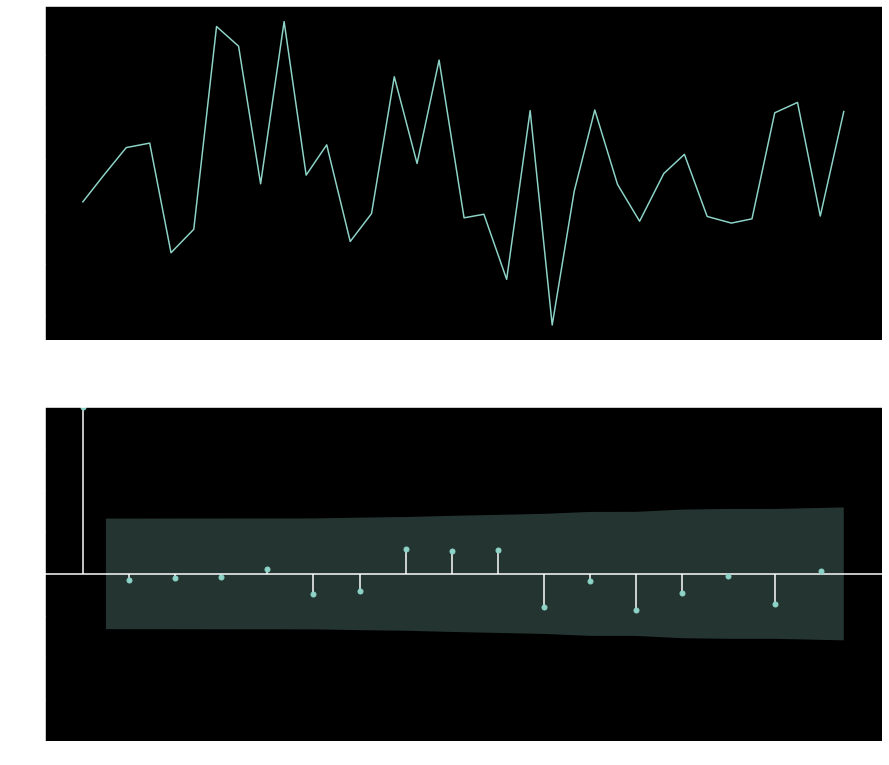

In [16]:
plt.figure(figsize=(15,15))

plt.subplot(211)
best_model.resid[(seasonal+1):].plot()

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[(seasonal+1):].values.squeeze(), ax=ax);

x:\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
x:\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:394: DeprecationWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  warnings.warn('No supported index is available. In the next'


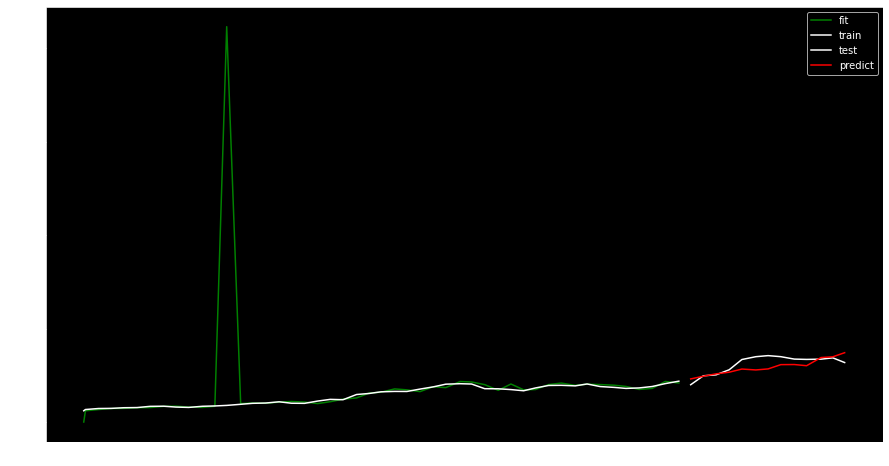

In [17]:
plt.figure(figsize=(15, 8))

y_fitted = np.exp(best_model.fittedvalues)
y_predicted = np.exp(best_model.forecast(len(X_test)))

plt.plot(X_train, y_fitted, c='g', label='fit')
plt.plot(X_train, y_train, c='w', label='train')

plt.plot(X_test, y_test, c='w', label='test')
plt.plot(X_test, y_predicted, c='r', label='predict')
plt.legend()
plt.show();

In [18]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(y_test, y_predicted)

0.10026272286551799